In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import helper_mate as h
import helper as hd
from colorscheme import *

from gt_learner import GT_learner
import gr_em_learner as gr_em

In [2]:
# Data parameters
SCHEDULE = 'BLOCKED' # 'BLOCKED' or 'INTERLEAVED' or 'CUSTOM'
T = 8 # only applies if SCHEDULE is 'BLOCKED' or 'INTERLEAVED

BLOCK_SIZE = 4 # only applies if SCHEDULE is 'CUSTOM'
N_BATCHES = 1 # only applies if SCHEDULE is 'CUSTOM'
T = N_BATCHES * 2 * BLOCK_SIZE
ALPHA_LIST = [45,-45]
N_RUNS = 50
EM_size_limit_for_eval_EM = 4
EM_size_limit_for_eval_GR = 1
# Agent parameters
SIGMA_R = .3
PP_THRESHOLD = 1000.0
D = 5
EM_SIZE_EM = 4
EM_SIZE_GR = 1

In [3]:
# Generate N_RUNS datasets
datasets = [h.generate_batch_data(ALPHA_LIST, BLOCK_SIZE, N_BATCHES) for i in range(N_RUNS)]

# Define models to be tested
model_set = ['x', 'y', '1x2D', '2x2D_bg']

# Compute mllhs
results = {'gt': [], 'gr': [], 'em': []}
pbar = tf.keras.utils.Progbar(N_RUNS)
for data in datasets:
    result = {}
    # Ground truth learner
    result['gt'] = GT_learner(data, SIGMA_R, model_set)
    results['gt'].append(result['gt'])

    # Generative replay learner
    result['gr'] = gr_em.GR_EM_learner(data, SIGMA_R, model_set, EM_size_limit_for_eval_GR, verbose=False,
                               EM_size_limit=EM_SIZE_GR, pp_thr=PP_THRESHOLD*100, D=D)
    results['gr'].append(result['gr'])

    # Episodic learner
    result['em'] = gr_em.GR_EM_learner(data, SIGMA_R, model_set, EM_size_limit_for_eval_EM, verbose=False,
                               EM_size_limit=EM_SIZE_EM, pp_thr=PP_THRESHOLD*100, D=D)
    results['em'].append(result['em'])

    pbar.add(1)

/content/gr_em_learner.py:236: RuntimeWarning: divide by zero encountered in log
  mean_of_log_mmllh = np.mean(np.log(model_props['mmllh']), axis = 0)
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


50/50 [==============================] - 44s 889ms/step


## Analysis

### Switching times

In [4]:
# Compute switching times
switch_times_wnan = {}
switch_times = {}
l = ['gt', 'gr', 'em']
#l = ['gt', 'em']
for agent in l:
    #switch_times_wnan[agent] = [hd.model_change_time(results[agent][i], model_set[-1])
                                # for i in range(N_RUNS)]
    switch_times_wnan[agent] = [T if results[agent][i]['prominent_models'][-1] == '2x2D_bg' else np.nan for i in range(N_RUNS) ]
# replace nans with T + 1
for agent in l:
    switch_times[agent] = [x if not np.isnan(x) else T+1 for x in switch_times_wnan[agent]]

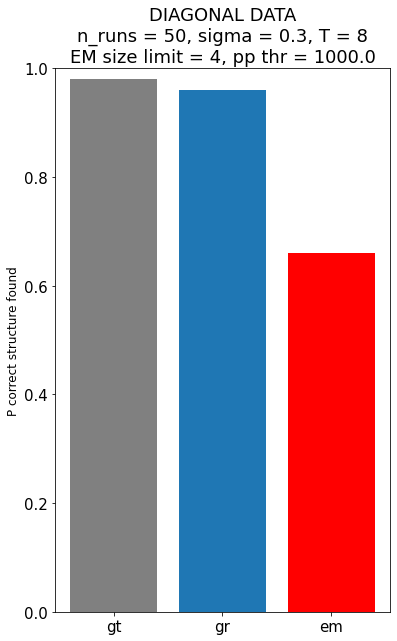

In [10]:
# Count succesful find ground truth models within T trials
color_dict = {'gt': 'gray', 'gr': 'C0', 'em': 'red'}
fig, ax = plt.subplots(1,1, figsize = (6,10))
for agent in l:
    ax.bar(agent, (N_RUNS - np.sum(np.isnan(switch_times_wnan[agent])))/N_RUNS, color = color_dict[agent])
ax.set_ylabel('P correct structure found', fontsize=12)
ax.set_ylim([0, 1])
plt.title(f'DIAGONAL DATA\nn_runs = {N_RUNS}, sigma = {SIGMA_R}, T = {T}\nEM size limit = {EM_SIZE_EM}, pp thr = {PP_THRESHOLD}')
plt.savefig('p_correct_structure.pdf')
# plt.gcf().set_size_inches((2,3))

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)
fig.set_size_inches(12, 4)
for i, agent in enumerate(['gt', 'gr', 'em']):    
    axs[i].hist(switch_times[agent], label = agent, color = color_dict[agent])
    axs[i].set_title(agent)
    axs[i].set_xlabel('Switching time')
    axs[i].set_ylabel('Count')
    axs[i].set_xlim(0, T)
    axs[i].set_ylim(0, N_RUNS)
fig.suptitle('Switching time distributions for different agents, $\\sigma_r$ = {}, EM size = {}, PP threshold = {}'.format(SIGMA_R, EM_SIZE, PP_THRESHOLD),fontsize=14)
plt.gcf().set_size_inches((10,3))
plt.show()


In [ ]:
# Scatter plot of switching times with some noise added to points to avoid overlapping
T = BLOCK_SIZE * N_BATCHES * 2
epsilon = 0.3
plt.figure(figsize=(6,6))
plt.scatter(switch_times['gt'] + epsilon*np.random.randn(N_RUNS), switch_times['gr'] + epsilon*np.random.randn(N_RUNS))
plt.scatter(switch_times['gt'] + epsilon*np.random.randn(N_RUNS), switch_times['em'] + epsilon*np.random.randn(N_RUNS), color = 'r')
plt.xlabel('GT switching time')
plt.ylabel('GR/EM switching time')
plt.xlim([0, T+1.7])
plt.ylim([0, T+1.7])

#add legend outside of plot
plt.legend(['GR vs GT', 'EM vs GT'], loc='upper left', bbox_to_anchor=(1, 1))

#add dashed diagonal line
plt.plot([0, T+1.7], [0, T+1.7], '--')

plt.plot([0, T+1.7], [T+0.5, T+0.5], '--', color = 'lightgray')
plt.plot([T+0.5, T+0.5], [0, T+1.7], '--', color = 'lightgray')

plt.text((T+1.7)*1.05, T*0.1, 'SIGMA_R = ' + str(SIGMA_R))
plt.text((T+1.7)*1.05, T*0.2, 'EM_SIZE = ' + str(EM_SIZE))
plt.text((T+1.7)*1.05, T*0.3, 'PP_THRESHOLD = ' + str(PP_THRESHOLD))

plt.title('schedule = {}'.format(SCHEDULE))

plt.gcf().set_size_inches((4,4))

plt.show()

In [ ]:
# GR vs EM switching time
T = BLOCK_SIZE * (N_BATCHES + 1)
plt.figure(figsize=(6,6))
plt.scatter(switch_times['gr'] + epsilon*np.random.randn(N_RUNS), switch_times['em'] + epsilon*np.random.randn(N_RUNS),c='k')
plt.plot([0, T], [0, T], '--')
plt.xlabel('GR switching time')
plt.ylabel('EM switching time')
plt.xlim([0, T])
plt.ylim([0, T])
plt.gcf().set_size_inches((4,4))
plt.show()

### Evolution of mllhs

In [ ]:
i = 8
learning_dicts = [results['gt'][i], results['gr'][i], results['em'][i]]
hd.plot_mllh_curves_subpanels(learning_dicts, model_set, T=len(data['c']), color_dict=model_colors_gergo, figsize=(15,4), data=datasets[0], markersize=5)

In [ ]:
# Plot mllhs
hd.plot_mmllh_curves(results['gt'][i], model_set, T=len(data['c']), color_dict=model_colors_gergo, figsize=(15,4), data=datasets[0])
hd.plot_mmllh_curves(results['gr'][i], model_set, T=len(data['c']), color_dict=model_colors_gergo, figsize=(15,4), data=datasets[0])
hd.plot_mmllh_curves(results['em'][i], model_set, T=len(data['c']), color_dict=model_colors_gergo, figsize=(15,4), data=datasets[0])